### Full detector-classifier pipeline
1. crop terns images from train folder {rot, sat, unknown}

2. train a resnet-50 classifier based on those images

3. validate on the val set that's cropped according to ground truth annotations

4. validate on the val/test set detector results 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

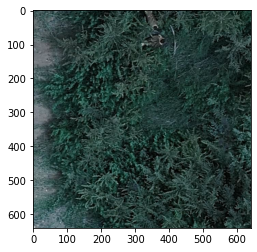

In [2]:
%load_ext autoreload
%autoreload 2

import os
import cv2
import numpy as np
import pandas as pd
from glob import glob 
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import torch
import torch.optim
import torchvision.models as models
from torchvision import transforms, utils
from torch.utils.data import DataLoader

from utils.confmat import plot_confusion_matrix
from utils.pipeline2 import train_test_split, TernsDataset, train_model



In [ ]:
device = torch.device('cuda')

data_root = './data/22F_new/'
tile_fold_name = 'split'
crop_fold_name = 'tcrop2'
tile_fd = os.path.join(data_root, tile_fold_name)
crop_fd = os.path.join(data_root, crop_fold_name)


for phase in ['Train', 'Validate', 'Test']:
    crop_fd_split = os.path.join(crop_fd, phase)
    if os.path.exists(crop_fd_split):
        continue
    os.makedirs(crop_fd_split, exist_ok=True)
    
    for i, f_til in tqdm(enumerate(sorted(glob(os.path.join(tile_fd, f'{phase}/*'))))):
        ext = f_til.split('.')[-1]
        if not ext.lower() in ['jpg', 'jpeg']:
            continue
        f_ann  = f_til.replace(ext, 'csv')
        df_ann = pd.read_csv(f_ann)
        img_til = cv2.imread(f_til)
        plt.imshow(img_til)

        for ii, df_img in df_ann.iterrows():
            img_crp = img_til[df_img.y:(df_img.y+df_img.height), df_img.x:(df_img.x+df_img.width)]
            img_lab = 'OTH' if df_img.class_id not in ['ROT', 'SAT'] else df_img.class_id

            img_sname = os.path.join(os.path.dirname(f_til).replace(tile_fold_name, crop_fold_name), 
                         f'{os.path.basename(f_til)[:-len(ext)]}{ii:04d}_{img_lab}.{ext}')
            cv2.imwrite(img_sname, img_crp)

# plt.imshow(img_crp)

In [5]:
# csv
for phase in ['Train', 'Validate', 'Test']:
    fn_csv = os.path.join(crop_fd, f'{phase}.csv')
    if os.path.exists(fn_csv):
        continue
    df_dataset = pd.DataFrame(columns={'filename', 'class'})

    for f_img in tqdm(sorted(glob(os.path.join(crop_fd, f'{phase}/*')))):
        ext = f_img.split('.')[-1]
        if not ext.lower() in ['jpg', 'jpeg']:
            continue
        fln = os.path.basename(f_img)
        lab = fln.split('_')[-1].split('.')[0]

        df_dataset.loc[len(df_dataset.index)] = {'filename':fln, 'class':lab}

    df_dataset.to_csv(fn_csv, index=False)
    
# split images cropped from training tiles
train_test_split(os.path.join(crop_fd, 'Train.csv'))

In [6]:
from sklearn.utils.class_weight import compute_class_weight
ds_train = pd.read_csv(os.path.join(crop_fd, 'Train-train.csv'))
class_count = ds_train[['class']].value_counts()

# x = torch.randn(20, 5) 
# y = torch.randint(0, 5, (20,)) # classes
# class_weights=compute_class_weight('balanced', classes=total_dataset['new_class'].unique(),
#                                     y=total_dataset['new_class'].values)
# class_weights=torch.tensor(class_weights,dtype=torch.float)
class_count


class
ROT      4855
SAT      2898
OTH       377
dtype: int64

In [8]:

batch_size = 1000
n_epochs = 50
learningRate = 1e-4

cost_function = torch.nn.CrossEntropyLoss()#weight=class_weights,reduction='mean')
model = models.resnet50(pretrained=True)
in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features, 3)

# optimizer = torch.optim.SGD(model.parameters(), lr = learningRate, momentum=0.9, 
#                             weight_decay=5e-6, nesterov=True)
optimizer = torch.optim.Adam(model.parameters(), lr = learningRate, weight_decay=5e-6)

UNI_SIZE = 48
class Flatten(object):
    def __call__(self, input_tensor):
        return input_tensor.view(3, UNI_SIZE, UNI_SIZE)

train_transform = transforms.Compose([transforms.Resize((UNI_SIZE, UNI_SIZE)),
                                transforms.RandomResizedCrop(UNI_SIZE),
                                transforms.RandomHorizontalFlip(), # data augmentation
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
transform = transforms.Compose([transforms.Resize((UNI_SIZE, UNI_SIZE)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# datasets
training   = TernsDataset(os.path.join(crop_fd, 'Train-train.csv'), 
                          root_dir  = os.path.join(crop_fd, 'Train'), 
                          transform = train_transform)
validation = TernsDataset(os.path.join(crop_fd, 'Train-valid.csv'),
                          root_dir  = os.path.join(crop_fd, 'Train'), 
                          transform = transform)

# data loaders
train_loader = torch.utils.data.DataLoader(training, 
                                           batch_size = batch_size, 
                                           shuffle = True, 
                                           pin_memory = True,
                                           num_workers = 8)
val_loader = torch.utils.data.DataLoader(validation, 
                                         batch_size = batch_size, 
                                         shuffle = False)


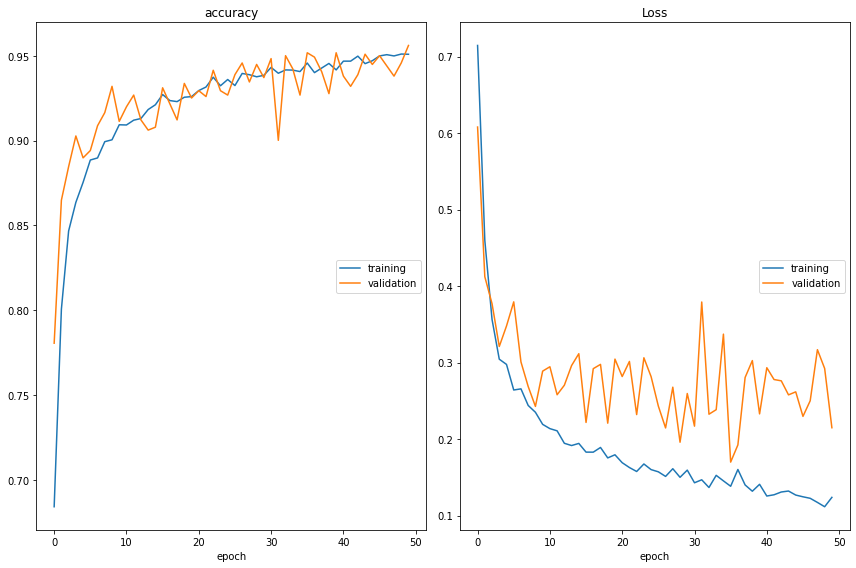

accuracy
	training         	 (min:    0.684, max:    0.951, cur:    0.951)
	validation       	 (min:    0.781, max:    0.956, cur:    0.956)
Loss
	training         	 (min:    0.111, max:    0.715, cur:    0.124)
	validation       	 (min:    0.170, max:    0.608, cur:    0.215)


In [12]:
train_model(batch_size, n_epochs, learningRate, 
            model, cost_function, optimizer, -1, 
            train_loader, val_loader, device);

In [15]:
testing = TernsDataset(os.path.join(crop_fd, 'Test.csv'),
                       root_dir  = os.path.join(crop_fd, 'Test'), 
                       transform = transform)
test_loader = torch.utils.data.DataLoader(testing, 
                                         batch_size = batch_size, 
                                         shuffle = False)

model.load_state_dict(torch.load('best_model_so_far.pth'))
model.to(device)
model.eval()

y_prob, y_true = [], []
with torch.no_grad():
    # Run the model on the validation set to keep track of accuracy there.
    for (batch_id, (xb, yb)) in enumerate(test_loader):

        # Move data to GPU if needed.
        xb = xb.to(device)
        yb = yb.to(device)

        # Compute predictions.
        logits = model(xb)
        proba  = logits.detach().softmax(dim = 1)
        
        y_true.append(yb.cpu().numpy())
        y_prob.append(proba.cpu().numpy())
    
y_true = np.concatenate(y_true)
y_prob = np.concatenate(y_prob)
y_pred = np.argmax(y_prob, -1)


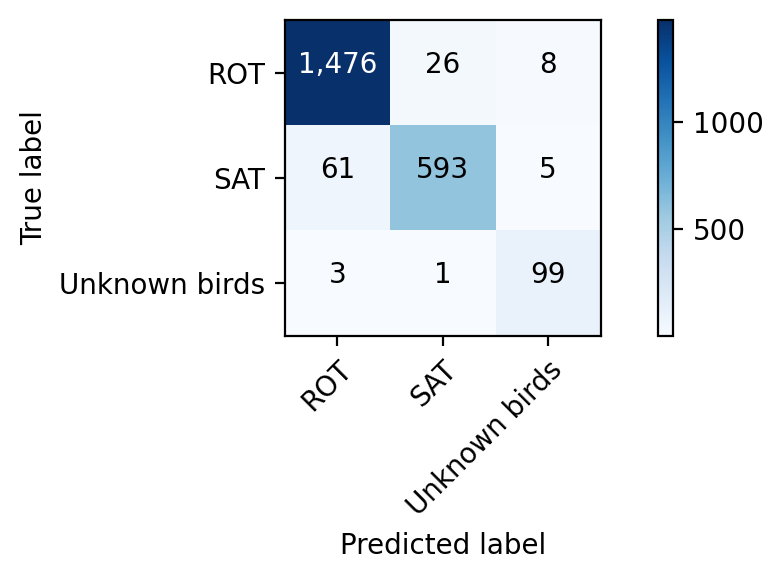

In [17]:
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(1,1, figsize=(6,3), dpi=200)
plot_confusion_matrix(cm, ['ROT', 'SAT', 'Unknown birds'], figure=(fig, ax), normalize=False)

## Detector results

In [20]:
out_dir = '../Audubon_S22_WB/output/Training_models_terns/06_22_bay_tune_retina_2class_set_I_aug_WLx1000/predicted_results/'
lab_cat2cls = {0: 'ROT', 1: 'SAT', 2: 'OTH'}

df_dataset = pd.DataFrame(columns={'filename', 'class'})
for f_pred_img in tqdm(sorted(glob(out_dir+'*'))):
    ext = f_pred_img.split('.')[-1]
    if not ext.lower() in ['jpg', 'jpeg']:
        continue
    fln = os.path.basename(f_pred_img)
    df_dataset.loc[len(df_dataset.index)] = {
        'filename': fln, 
        'class'   : lab_cat2cls[int(fln.split('_')[-1].split('.')[0])]
    }
        
df_dataset.to_csv(os.path.join(out_dir, 'Test.csv'), index=False) 

  0%|          | 0/2538 [00:00<?, ?it/s]

In [21]:
testing_dect = TernsDataset(os.path.join(out_dir, 'Test.csv'), 
                          root_dir  = out_dir, 
                          transform = transform)

test_loader_dect = torch.utils.data.DataLoader(testing_dect, 
                                         batch_size = batch_size, 
                                         shuffle = False)

model.load_state_dict(torch.load('best_model_so_far.pth'))
model.to(device)
model.eval()

y_prob, y_true = [], []
with torch.no_grad():
    # Run the model on the validation set to keep track of accuracy there.
    for (batch_id, (xb, yb)) in enumerate(test_loader_dect):

        # Move data to GPU if needed.
        xb = xb.to(device)
        yb = yb.to(device)

        # Compute predictions.
        logits = model(xb)
        proba  = logits.detach().softmax(dim = 1)
        
        y_true.append(yb.cpu().numpy())
        y_prob.append(proba.cpu().numpy())
    
y_true = np.concatenate(y_true)
y_prob = np.concatenate(y_prob)
y_pred = np.argmax(y_prob, -1)

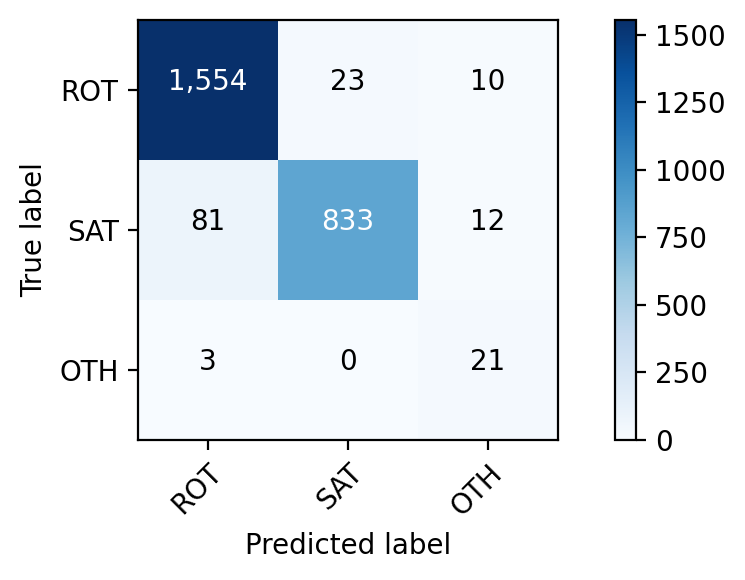

In [23]:
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(1,1, figsize=(6,3), dpi=200)
plot_confusion_matrix(cm, ['ROT', 'SAT', 'OTH'], figure=(fig, ax), normalize=False)